In [1]:
import os
import random 
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

2.0.1+cu117
0.15.2+cu117


In [2]:
dataset_location = utils.load_rf_data(8)
dataset_location

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.153, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to Football-Player-Detection-8 in yolov8:: 100%|██████████| 115/115 [00:00<00:00, 3535.61it/s]


'/home/mikkel/VSC/football-player-detection/Football-Player-Detection-8'

In [3]:
os.listdir(f"{dataset_location}/train/images")

['0b1495d3_1_mp4-6_jpg.rf.c22374d6e8a8cffe9d8f59eb778a88bb.jpg',
 '0b1495d3_0_mp4-8_jpg.rf.41d36e3782fbaea024a3768566c2eb99.jpg',
 '4dae79a9_0_mp4-1_jpg.rf.da1edbbd02e1a35afacbd37f243b0e1d.jpg',
 '2f54ed1c_0_mp4-0_jpg.rf.996817f8fc76090def995c9732615b57.jpg',
 '0b1495d3_0_mp4-0_jpg.rf.e50ef4d39b81adc248bda0b401c88fc4.jpg',
 '0b1495d3_0_mp4-0_jpg.rf.ca741cd9d337202959249e6cd18afdad.jpg',
 '9a70c54e_1_mp4-0_jpg.rf.952a64f5b62e78917a64f6b177599160.jpg',
 '0b1495d3_0_mp4-5_jpg.rf.3470dc2abf32b0d621229b88b6981627.jpg',
 '0b1495d3_1_mp4-0_jpg.rf.2503c68f752506af07e1202a93693b11.jpg',
 '0b1495d3_1_mp4-7_jpg.rf.1a1602e2cb4ccc1290b3e7a722e0cc2f.jpg',
 '0b1495d3_0_mp4-4_jpg.rf.7a860741f643727c09c3406712a64dc2.jpg',
 '0b1495d3_0_mp4-8_jpg.rf.363420f63286194974fda2e490cca99e.jpg',
 '4dae79a9_0_mp4-4_jpg.rf.18d0813adb387ab2e29c4a5bb868eafe.jpg',
 '9f4df856_0_mp4-2_jpg.rf.37ba88ec6f6ebe086fbdbeb7030cf918.jpg',
 '0b1495d3_0_mp4-1_jpg.rf.4972fa3d70659da3d041b34e99427ad2.jpg',
 '2f54ed1c_0_mp4-0_jpg.rf

In [4]:
import yaml

class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset_location, dataset_type, imgsz=640, transforms=None):

        self.imgsz = imgsz
        self.transforms = transforms
        self.dataset_type = dataset_type
        with open(f"{dataset_location}/data.yaml") as f:
            doc = yaml.safe_load(f)
            self.img_dir = doc[dataset_type]+"/images"           
            self.label_dir = doc[dataset_type]+"/labels"
            self.classes = doc['names']
            self.classes.insert(0, "background")

        self.imgs = [image for image in sorted(os.listdir(self.img_dir)) if image.endswith(".jpg")]

    def __getitem__(self, index):
        img_name = self.imgs[index]
        image_path = os.path.join(self.img_dir, img_name)
        
        # Converting images to correct size and color
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        aspect_ratio = img.shape[0] / img.shape[1]
        height = int(aspect_ratio * self.imgsz)
        img = cv2.resize(img, (self.imgsz, height), interpolation=cv2.INTER_AREA)

        img /= 255.0

        annot_filename = img_name[:-4] + ".txt"
        annot_path = os.path.join(self.label_dir, annot_filename)

        boxes = []
        labels = []
        with open(annot_path, "r") as f:
            for line in f:
                class_id, x, y, w, h = line.strip().split()
                class_id = int(class_id)
                x_min = float(x) - float(w) / 2
                y_min = float(y) - float(h) / 2
                x_max = float(x) + float(w) / 2
                y_max = float(y) + float(h) / 2

                x_min = int(x_min * self.imgsz)
                y_min = int(y_min * height)
                x_max = int(x_max * self.imgsz)
                y_max = int(y_max * height)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([index])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        if self.transforms:
            sample = self.transforms(image=img, bboxes=target['boxes'], labels=labels)
            img = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)   

        return img, target
    
    
    def __len__(self):
        return len(self.imgs)
    

dataset = Dataset(dataset_location, dataset_type="train",imgsz=640)
print(len(dataset))
img, target = dataset[0]
print(img.shape)

47
(360, 640, 3)


In [5]:
def get_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
def show_annotated_image(img, target):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box in target['boxes']:
        x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

    cv2.imshow('img', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

img, target = dataset[10]
show_annotated_image(img, target)

In [7]:
def get_object_detection_model(num_classes):

    # load model pretrained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pretrained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
batch_size = 4

train_dataset = Dataset(dataset_location, dataset_type="train", imgsz=640, transforms=get_transform())
val_dataset = Dataset(dataset_location, dataset_type="val", imgsz=640, transforms=get_transform())

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 1 + 4 # background + 4 classes

model = get_object_detection_model(num_classes)
model.to(device)

params  = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.


In [10]:
epochs = 100

for epoch in range(epochs):

    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)

    lr_scheduler.step()

    #evaluate(model, val_loader, device=device)

Epoch: [0]  [ 0/12]  eta: 0:00:22  lr: 0.000459  loss: 3.0569 (3.0569)  loss_classifier: 1.6458 (1.6458)  loss_box_reg: 0.5424 (0.5424)  loss_objectness: 0.6442 (0.6442)  loss_rpn_box_reg: 0.2245 (0.2245)  time: 1.8731  data: 0.2702  max mem: 7565
Epoch: [0]  [10/12]  eta: 0:00:02  lr: 0.005000  loss: 1.7119 (2.1605)  loss_classifier: 0.8044 (0.9580)  loss_box_reg: 0.5688 (0.5751)  loss_objectness: 0.1089 (0.4257)  loss_rpn_box_reg: 0.1949 (0.2018)  time: 1.0365  data: 0.0279  max mem: 7729
Epoch: [0]  [11/12]  eta: 0:00:01  lr: 0.005000  loss: 1.4171 (2.0779)  loss_classifier: 0.5531 (0.9117)  loss_box_reg: 0.5688 (0.5761)  loss_objectness: 0.1052 (0.3989)  loss_rpn_box_reg: 0.1890 (0.1913)  time: 1.0109  data: 0.0258  max mem: 7729
Epoch: [0] Total time: 0:00:12 (1.0127 s / it)
Epoch: [1]  [ 0/12]  eta: 0:00:14  lr: 0.005000  loss: 1.1755 (1.1755)  loss_classifier: 0.3595 (0.3595)  loss_box_reg: 0.6133 (0.6133)  loss_objectness: 0.1162 (0.1162)  loss_rpn_box_reg: 0.0864 (0.0864)  tim

In [11]:
img = cv2.imread(f"{dataset_location}/valid/images/9f4df856_0_mp4-1_jpg.rf.1463a2e74baaa167f9152848d82589b8.jpg")
img.shape

(1080, 1920, 3)

Image device: cuda:0
Model device: CUDA


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


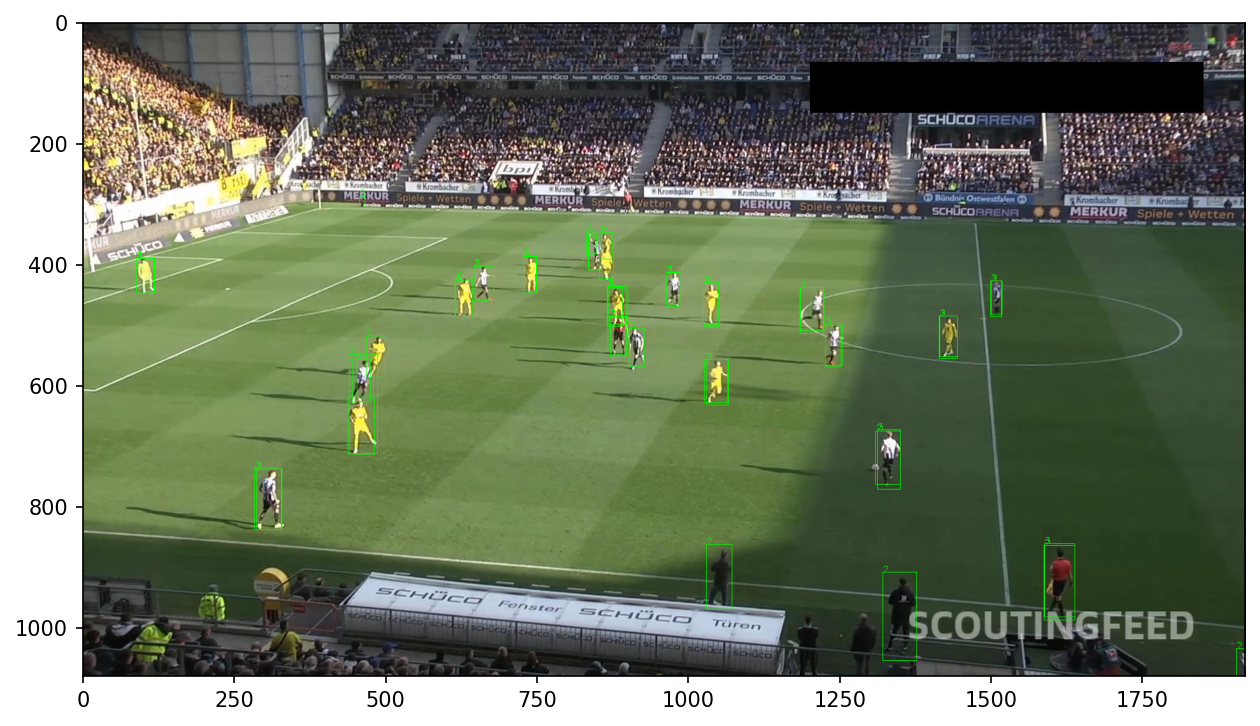

In [12]:
from rcnn_utils import inference

inference(img, model, device)